# Injury Datasets - CLEANING / PREPARING

## context
source
https://doi.org/10.34894/UWU9PV

This two Datasets, published by the dutch University of Groningen is collecting training data of 74 athletes over a period of 7 years.
Together they group a team of middle-distance to long-distance runners and over the time they combined account for 583 injuries.

Each Dataset shows >42,000 events (indexed by DayNumber) that are either a normal day or a day with an injury. There are two perspectives 
- a micro perspective that looks at the 7 days before the event
- a macro perspective that looks at the 3 weeks before the event

So there is a list of 
 - 10 metrics for days, repeated 7 times 
 - 22 metrics for weeks, repeated 3 times. 

These are metrics on the topics 
- number of Sessions
- number of Rest Days
- mileage
- mileage in different heart rate zones 
- alternative training like cycling or swimming
- strength training

and three subjectively entered 
- recovery
- exertion
- training success

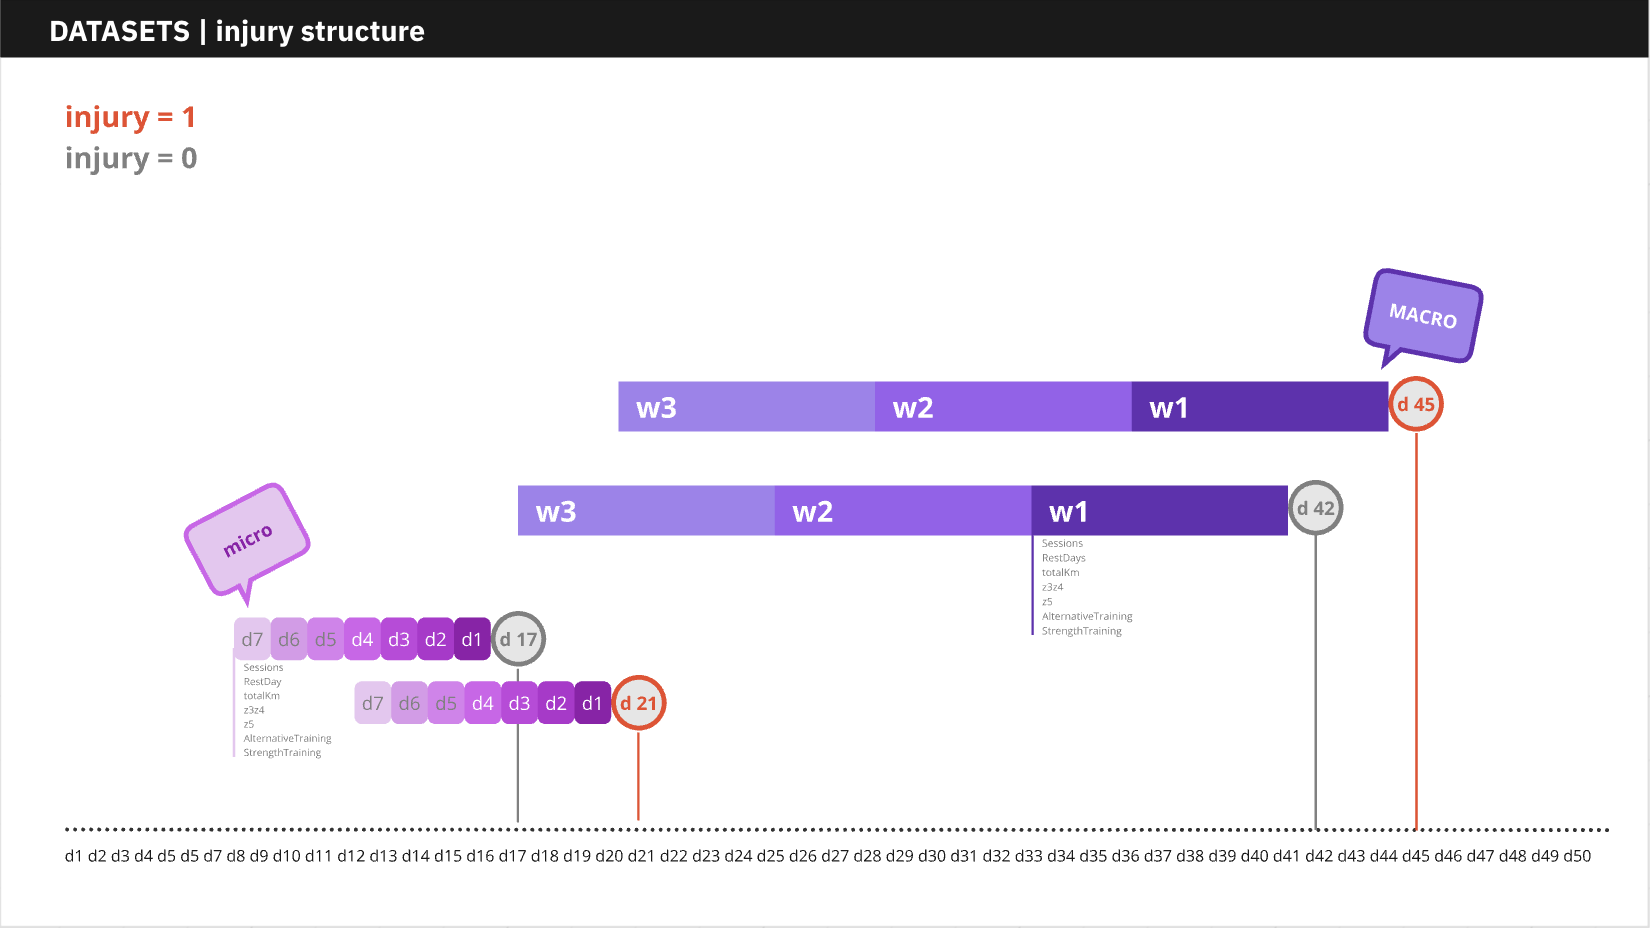

## aim
The main task is understanding these complex datasets and than make them more intuitively understandable by changing column names.

## process
1. EDA
2. cleaning and preparing the macro perspective "week"
    - The column for "relative change of total km" in the dataset was only calculated as a division from one period to another. That posed problems with the numbers. So I changed the mathematical approach to a logarithmic scaling and also added another new column that aims for differences and changes.
3. cleaning and preparing the micro perspective "days"
    - The Dataset in micro perspective (days) has an error in the sequence. The 'nr. session 6' is not 7 days before the event but one day before the event. So I correct the order and replace 0-6 (=7days before until 1 day before) to 7-1 (=7days before until 1 day before).
4. export to the database

## result
uploading the datasets df_inj_weeks_clean & df_inj_days_clean as prepared datasets for analyses

--------------------------------------

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# _. reading data

In [2]:
df_week_raw = pd.read_csv('../data_capestone/Predict injuries/week_approach_maskedID_timeseries.csv')

In [3]:
df_days_raw = pd.read_csv('../data_capestone/Predict injuries/day_approach_maskedID_timeseries.csv')

# 1. EDA

# 1.1 df_weeks

In [4]:
df_week_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42798 entries, 0 to 42797
Data columns (total 72 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   nr. sessions                                   42798 non-null  float64
 1   nr. rest days                                  42798 non-null  float64
 2   total kms                                      42798 non-null  float64
 3   max km one day                                 42798 non-null  float64
 4   total km Z3-Z4-Z5-T1-T2                        42798 non-null  float64
 5   nr. tough sessions (effort in Z5, T1 or T2)    42798 non-null  float64
 6   nr. days with interval session                 42798 non-null  float64
 7   total km Z3-4                                  42798 non-null  float64
 8   max km Z3-4 one day                            42798 non-null  float64
 9   total km Z5-T1-T2                              427

### check all columns

In [5]:
pd.set_option('display.max_columns', None)

df_week_raw.head(20)

,nr. sessions,nr. rest days,total kms,max km one day,total km Z3-Z4-Z5-T1-T2,"nr. tough sessions (effort in Z5, T1 or T2)",nr. days with interval session,total km Z3-4,max km Z3-4 one day,total km Z5-T1-T2,max km Z5-T1-T2 one day,total hours alternative training,nr. strength trainings,avg exertion,min exertion,max exertion,avg training success,min training success,max training success,avg recovery,min recovery,max recovery,nr. sessions.1,nr. rest days.1,total kms.1,max km one day.1,total km Z3-Z4-Z5-T1-T2.1,"nr. tough sessions (effort in Z5, T1 or T2).1",nr. days with interval session.1,total km Z3-4.1,max km Z3-4 one day.1,total km Z5-T1-T2.1,max km Z5-T1-T2 one day.1,total hours alternative training.1,nr. strength trainings.1,avg exertion.1,min exertion.1,max exertion.1,avg training success.1,min training success.1,max training success.1,avg recovery.1,min recovery.1,max recovery.1,nr. sessions.2,nr. rest days.2,total kms.2,max km one day.2,total km Z3-Z4-Z5-T1-T2.2,"nr. tough sessions (effort in Z5, T1 or T2).2",nr. days with interval session.2,total km Z3-4.2,max km Z3-4 one day.2,total km Z5-T1-T2.2,max km Z5-T1-T2 one day.2,total hours alternative training.2,nr. strength trainings.2,avg exertion.2,min exertion.2,max exertion.2,avg training success.2,min training success.2,max training success.2,avg recovery.2,min recovery.2,max recovery.2,Athlete ID,injury,rel total kms week 0_1,rel total kms week 0_2,rel total kms week 1_2,Date
0,5.0,2.0,22.2,16.4,11.8,1.0,2.0,10.0,10.0,0.6,0.6,2.08,2.0,0.10,0.08,0.11,0.0,0.0,0.0,0.17,0.15,0.18,6.0,1.0,30.9,13.8,13.5,0.0,2.0,12.4,6.4,0.0,0.0,2.08,2.0,0.1,0.09,0.12,0.0,0.0,0.0,0.17,0.16,0.18,3.0,4.0,16.1,9.9,3.9,0.0,1.0,3.2,3.2,0.0,0.0,0.00,1.0,0.09,0.08,0.10,0.0,0.0,0.0,0.18,0.16,0.20,0,0,0.718447,1.378882,1.919255,0
1,5.0,2.0,21.6,16.4,11.7,1.0,2.0,10.0,10.0,0.5,0.5,2.08,2.0,0.10,0.08,0.11,0.0,0.0,0.0,0.17,0.15,0.18,6.0,1.0,31.6,13.8,14.2,1.0,3.0,12.4,6.4,0.6,0.6,2.08,2.0,0.1,0.09,0.12,0.0,0.0,0.0,0.17,0.16,0.18,4.0,3.0,21.2,9.9,5.0,0.0,1.0,3.2,3.2,0.0,0.0,0.00,1.0,0.10,0.08,0.10,0.0,0.0,0.0,0.18,0.16,0.20,0,0,0.683544,1.018868,1.490566,1
2,5.0,2.0,21.6,16.4,11.7,1.0,2.0,10.0,10.0,0.5,0.5,2.08,2.0,0.10,0.08,0.11,0.0,0.0,0.0,0.17,0.15,0.18,6.0,1.0,31.6,13.8,14.2,1.0,3.0,12.4,6.4,0.6,0.6,2.08,2.0,0.1,0.09,0.12,0.0,0.0,0.0,0.17,0.16,0.18,3.0,4.0,21.2,9.9,5.0,0.0,1.0,3.2,3.2,0.0,0.0,0.00,0.0,0.10,0.10,0.10,0.0,0.0,0.0,0.17,0.16,0.18,0,0,0.683544,1.018868,1.490566,2
3,5.0,2.0,21.6,16.4,11.7,1.0,2.0,10.0,10.0,0.5,0.5,2.08,2.0,0.10,0.08,0.11,0.0,0.0,0.0,0.17,0.15,0.18,6.0,1.0,31.6,13.8,14.2,1.0,3.0,12.4,6.4,0.6,0.6,2.08,2.0,0.1,0.09,0.11,0.0,0.0,0.0,0.17,0.16,0.18,4.0,3.0,21.2,9.9,5.0,0.0,1.0,3.2,3.2,0.0,0.0,0.00,1.0,0.11,0.10,0.12,0.0,0.0,0.0,0.18,0.16,0.18,0,0,0.683544,1.018868,1.490566,3
4,6.0,1.0,39.2,17.6,18.9,1.0,3.0,17.2,10.0,0.5,0.5,2.08,2.0,0.10,0.08,0.11,0.0,0.0,0.0,0.17,0.15,0.18,5.0,2.0,17.8,12.0,7.8,1.0,2.0,6.0,6.0,0.6,0.6,2.08,2.0,0.1,0.09,0.11,0.0,0.0,0.0,0.17,0.16,0.18,4.0,3.0,28.8,13.8,10.7,0.0,2.0,9.6,6.4,0.0,0.0,0.00,1.0,0.11,0.10,0.12,0.0,0.0,0.0,0.17,0.16,0.18,0,0,2.202247,1.361111,0.618056,4
5,6.0,1.0,39.2,17.6,18.9,1.0,3.0,17.2,10.0,0.5,0.5,2.00,2.0,0.10,0.08,0.11,0.0,0.0,0.0,0.17,0.15,0.17,5.0,2.0,17.8,12.0,7.8,1.0,2.0,6.0,6.0,0.6,0.6,2.08,2.0,0.1,0.08,0.11,0.0,0.0,0.0,0.17,0.16,0.18,5.0,2.0,28.8,13.8,10.7,0.0,2.0,9.6,6.4,0.0,0.0,1.08,1.0,0.10,0.09,0.12,0.0,0.0,0.0,0.17,0.16,0.18,0,0,2.202247,1.361111,0.618056,5
6,6.0,1.0,33.3,17.6,15.4,1.0,3.0,13.7,7.2,0.5,0.5,2.00,1.0,0.10,0.08,0.11,0.0,0.0,0.0,0.17,0.15,0.18,5.0,2.0,22.2,16.4,11.8,1.0,2.0,10.0,10.0,0.6,0.6,2.08,2.0,0.1,0.08,0.11,0.0,0.0,0.0,0.17,0.16,0.18,5.0,2.0,30.9,13.8,13.5,0.0,2.0,12.4,6.4,0.0,0.0,1.08,2.0,0.10,0.09,0.12,0.0,0.0,0.0,0.17,0.16,0.18,0,0,1.500000,1.077670,0.718447,6
7,5.0,2.0,33.3,17.6,15.4,1.0,3.0,13.7,7.2,0.5,0.5,1.00,1.0,0.10,0.08,0.11,0.0,0.0,0.0,0.17,0.17,0.18,5.0,2.0,22.2,16.4,11.8,1.0,2.0,10.0,10.0,0.6,0.6,2.08,2.0,0.1,0.08,0.11,0.0,0.0,0.0,0.17,0.15,0.18,6.0,1.0,30.9,13.8,13.5,0.0,2.0,12.4

Is nr.session a categorical column that calls a session?

In [6]:
df_week_raw['nr. sessions'].unique()

array([ 5.,  6.,  7.,  4.,  3.,  2.,  8.,  9., 10.,  1.,  0., 11., 12.,
       13., 14.])

Conclusion is no - it is the count of sessions that can be 2 per day highest.

## check for nulls

In [7]:
df_week_raw.isnull().sum()

nr. sessions               0
nr. rest days              0
total kms                  0
max km one day             0
total km Z3-Z4-Z5-T1-T2    0
                          ..
injury                     0
rel total kms week 0_1     0
rel total kms week 0_2     0
rel total kms week 1_2     0
Date                       0
Length: 72, dtype: int64

## check for duplicats

In [8]:
duplicates_w = df_week_raw[df_week_raw.duplicated()]

print('Number of duplicats: ', len(duplicates_w))

Number of duplicats:  0


# 1.2 df_days

In [9]:
df_days_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42766 entries, 0 to 42765
Data columns (total 73 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   nr. sessions                 42766 non-null  float64
 1   total km                     42766 non-null  float64
 2   km Z3-4                      42766 non-null  float64
 3   km Z5-T1-T2                  42766 non-null  float64
 4   km sprinting                 42766 non-null  float64
 5   strength training            42766 non-null  float64
 6   hours alternative            42766 non-null  float64
 7   perceived exertion           42766 non-null  float64
 8   perceived trainingSuccess    42766 non-null  float64
 9   perceived recovery           42766 non-null  float64
 10  nr. sessions.1               42766 non-null  float64
 11  total km.1                   42766 non-null  float64
 12  km Z3-4.1                    42766 non-null  float64
 13  km Z5-T1-T2.1   

### check all columns

In [10]:
pd.set_option('display.max_columns', None)

df_days_raw.head(20)

,nr. sessions,total km,km Z3-4,km Z5-T1-T2,km sprinting,strength training,hours alternative,perceived exertion,perceived trainingSuccess,perceived recovery,nr. sessions.1,total km.1,km Z3-4.1,km Z5-T1-T2.1,km sprinting.1,strength training.1,hours alternative.1,perceived exertion.1,perceived trainingSuccess.1,perceived recovery.1,nr. sessions.2,total km.2,km Z3-4.2,km Z5-T1-T2.2,km sprinting.2,strength training.2,hours alternative.2,perceived exertion.2,perceived trainingSuccess.2,perceived recovery.2,nr. sessions.3,total km.3,km Z3-4.3,km Z5-T1-T2.3,km sprinting.3,strength training.3,hours alternative.3,perceived exertion.3,perceived trainingSuccess.3,perceived recovery.3,nr. sessions.4,total km.4,km Z3-4.4,km Z5-T1-T2.4,km sprinting.4,strength training.4,hours alternative.4,perceived exertion.4,perceived trainingSuccess.4,perceived recovery.4,nr. sessions.5,total km.5,km Z3-4.5,km Z5-T1-T2.5,km sprinting.5,strength training.5,hours alternative.5,perceived exertion.5,perceived trainingSuccess.5,perceived recovery.5,nr. sessions.6,total km.6,km Z3-4.6,km Z5-T1-T2.6,km sprinting.6,strength training.6,hours alternative.6,perceived exertion.6,perceived trainingSuccess.6,perceived recovery.6,Athlete ID,injury,Date
0,1.0,5.8,0.0,0.6,1.2,0.0,0.00,0.11,0.00,0.18,0.0,0.0,0.0,0.0,0.0,0.0,0.00,-0.01,-0.01,-0.01,1.0,0.0,0.0,0.0,0.0,1.0,0.00,0.10,0.00,0.17,0.0,0.0,0.0,0.0,0.0,0.0,0.00,-0.01,-0.01,-0.01,1.0,0.0,0.0,0.0,0.0,0.0,1.08,0.08,0.00,0.18,1.0,16.4,10.0,0.0,0.0,1.0,0.0,0.11,0.00,0.17,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.10,0.00,0.15,0,0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.00,-0.01,-0.01,-0.01,1.0,0.0,0.0,0.0,0.0,1.0,0.00,0.10,0.00,0.17,0.0,0.0,0.0,0.0,0.0,0.0,0.00,-0.01,-0.01,-0.01,1.0,0.0,0.0,0.0,0.0,0.0,1.08,0.08,0.00,0.18,1.0,16.4,10.0,0.0,0.0,1.0,0.00,0.11,0.00,0.17,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.10,0.00,0.15,1.0,5.2,0.0,0.5,1.2,0.0,0.0,0.10,0.00,0.17,0,0,1
2,1.0,0.0,0.0,0.0,0.0,1.0,0.00,0.10,0.00,0.17,0.0,0.0,0.0,0.0,0.0,0.0,0.00,-0.01,-0.01,-0.01,1.0,0.0,0.0,0.0,0.0,0.0,1.08,0.08,0.00,0.18,1.0,16.4,10.0,0.0,0.0,1.0,0.00,0.11,0.00,0.17,1.0,0.0,0.0,0.0,0.0,0.0,1.00,0.10,0.00,0.15,1.0,5.2,0.0,0.5,1.2,0.0,0.0,0.10,0.00,0.17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.01,-0.01,-0.01,0,0,2
3,0.0,0.0,0.0,0.0,0.0,0.0,0.00,-0.01,-0.01,-0.01,1.0,0.0,0.0,0.0,0.0,0.0,1.08,0.08,0.00,0.18,1.0,16.4,10.0,0.0,0.0,1.0,0.00,0.11,0.00,0.17,1.0,0.0,0.0,0.0,0.0,0.0,1.00,0.10,0.00,0.15,1.0,5.2,0.0,0.5,1.2,0.0,0.00,0.10,0.00,0.17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.01,-0.01,-0.01,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.10,0.00,0.17,0,0,3
4,1.0,0.0,0.0,0.0,0.0,0.0,1.08,0.08,0.00,0.18,1.0,16.4,10.0,0.0,0.0,1.0,0.00,0.11,0.00,0.17,1.0,0.0,0.0,0.0,0.0,0.0,1.00,0.10,0.00,0.15,1.0,5.2,0.0,0.5,1.2,0.0,0.00,0.10,0.00,0.17,0.0,0.0,0.0,0.0,0.0,0.0,0.00,-0.01,-0.01,-0.01,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.10,0.00,0.17,1.0,17.6,7.2,0.0,0.0,0.0,0.0,0.11,0.00,0.17,0,0,4
5,1.0,16.4,10.0,0.0,0.0,1.0,0.00,0.11,0.00,0.17,1.0,0.0,0.0,0.0,0.0,0.0,1.00,0.10,0.00,0.15,1.0,5.2,0.0,0.5,1.2,0.0,0.00,0.10,0.00,0.17,0.0,0.0,0.0,0.0,0.0,0.0,0.00,-0.01,-0.01,-0.01,1.0,0.0,0.0,0.0,0.0,1.0,0.00,0.10,0.00,0.17,1.0,17.6,7.2,0.0,0.0,0.0,0.0,0.11,0.00,0.17,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.08,0.00,0.17,0,0,5
6,1.0,0.0,0.0,0.0,0.0,0.0,1.00,0.10,0.00,0.15,1.0,5.2,0.0,0.5,1.2,0.0,0.00,0.10,0.00,0.17,0.0,0.0,0.0,0.0,0.0,0.0,0.00,-0.01,-0.01,-0.01,1.0,0.0,0.0,0.0,0.0,1.0,0.00,0.10,0.00,0.17,1.0,17.6,7.2,0.0,0.0,0.0,0.00,0.11,0.00,0.17,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.08,0.00,0.17,1.0,10.5,6.5,0.0,0.0,0.0,0.0,0.09,0.00,0.18,0,0,6
7,1.0,5.2,0.0,0.5,1.2,0.0,0.00,0.10,0.00,0.17,0.0,0.0,0.0,0.0,0.0,0.0,0.00,-0.01,-0.01,-0.01,1.0,0.0,0.0,0.0,0.0,1.0,0.00,0.10,0.00,0.17,1.0,17.6,7.2,0.0,0.0,0.0,0.00,0.11,0.00,0.17,1.0,0.0,0.0,0.0,0.0,0.0,1.00,0.08,0.00,0.17,1.0,10.5,6.5,0.0,0.0,0.0,0.0,0.09,0.00,0.18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.01,-0.01,-0.01,0,0,7
8,0.0,0.0,0.0,0.0,0.0,0.0,0.00,-0.01,-0.01,-0.01,1.0,0.0,0.0,0.0,0.0,1.0,0.00,0.10,0.00,0.17,1.0,17.6,7.2,0.0,0.0,0.0,0.00,0.11,0.00,0.17,1.0,0.0,0.0,0.0,0.0,0.0,1.00,0.08,0.00,0.17,1.0,10.5,6.5,0.0,0.0

## check for nulls

In [11]:
df_days_raw.isnull().sum()

nr. sessions                   0
total km                       0
km Z3-4                        0
km Z5-T1-T2                    0
km sprinting                   0
                              ..
perceived trainingSuccess.6    0
perceived recovery.6           0
Athlete ID                     0
injury                         0
Date                           0
Length: 73, dtype: int64

## check for duplicats

In [12]:
duplicates_d = df_days_raw[df_week_raw.duplicated()]

print('Number of duplicats: ', len(duplicates_d))

Number of duplicats:  0


# 2. clean/prep : WEEKS

In [13]:
list(df_week_raw.columns)

['nr. sessions',
 'nr. rest days',
 'total kms',
 'max km one day',
 'total km Z3-Z4-Z5-T1-T2',
 'nr. tough sessions (effort in Z5, T1 or T2)',
 'nr. days with interval session',
 'total km Z3-4',
 'max km Z3-4 one day',
 'total km Z5-T1-T2',
 'max km Z5-T1-T2 one day',
 'total hours alternative training',
 'nr. strength trainings',
 'avg exertion',
 'min exertion',
 'max exertion',
 'avg training success',
 'min training success',
 'max training success',
 'avg recovery',
 'min recovery',
 'max recovery',
 'nr. sessions.1',
 'nr. rest days.1',
 'total kms.1',
 'max km one day.1',
 'total km Z3-Z4-Z5-T1-T2.1',
 'nr. tough sessions (effort in Z5, T1 or T2).1',
 'nr. days with interval session.1',
 'total km Z3-4.1',
 'max km Z3-4 one day.1',
 'total km Z5-T1-T2.1',
 'max km Z5-T1-T2 one day.1',
 'total hours alternative training.1',
 'nr. strength trainings.1',
 'avg exertion.1',
 'min exertion.1',
 'max exertion.1',
 'avg training success.1',
 'min training success.1',
 'max training s

### 2.1 clean: rename columns

I rename the columns to more meaningfull names. 
Preparing the Data for tabelau, too, I chose a combination of _ and CamelCase.

It stays complex, as we are looking at some chronologicaly repeating timeperiods, but the structure gets a little bit more intuitive with:

w1_ = "one week before the event", 

w2_ = "two weeks before the event"  

w3_ = "three weeks before the event" 

In [14]:
df_weeks = df_week_raw

# lowercase, space to '_', get rid of special characters, 
df_weeks.columns = df_weeks.columns.str.lower().str.replace(" ", "_").str.replace(r"[^\w]", "", regex=True)

In [15]:
# renaming the columns manually

df_weeks = df_weeks.rename(columns={
 'nr_sessions': 'w1_Sessions',
 'nr_rest_days': 'w1_RestDays',
 'total_kms': 'w1_TotalKm',
 'max_km_one_day' : 'w1_MaxKmDay',
 'total_km_z3z4z5t1t2': 'w1_TotalKm_z3z4z5',
 'nr_tough_sessions_effort_in_z5_t1_or_t2': 'w1_ToughSessions_z5',
 'nr_days_with_interval_session' : 'w1_DaysIntervalSessions',
 'total_km_z34' : 'w1_TotalKm_z3z4',
 'max_km_z34_one_day' : 'w1_MaxKmDay_z3z4',
 'total_km_z5t1t2': 'w1_TotalKm_z5',
 'max_km_z5t1t2_one_day' : 'w1_MaxKmDay_z5',
 'total_hours_alternative_training' : 'w1_HoursAlternativeTraining',
 'nr_strength_trainings' : 'w1_StrengthTrainings',
 'avg_exertion' : 'w1_AvgExertion',
 'min_exertion' : 'w1_MinExertion',
 'max_exertion': 'w1_MaxExertion',
 'avg_training_success' : 'w1_AvgTrainingSuccess',
 'min_training_success' : 'w1_MinTrainingSuccess',
 'max_training_success' : 'w1_MaxTrainingSuccess',
 'avg_recovery' : 'w1_AvgPreRest',
 'min_recovery' : 'w1_MinPreRest',
 'max_recovery' : 'w1_MaxPreRest',
#
 'nr_sessions1' : 'w2_Sessions',
 'nr_rest_days1' : 'w2_RestDays',
 'total_kms1' : 'w2_TotalKm',
 'max_km_one_day1' : 'w2_MaxKmDay',
 'total_km_z3z4z5t1t21' : 'w2_TotalKm_z3z4z5',
 'nr_tough_sessions_effort_in_z5_t1_or_t21' : 'w2_ToughSessions_z5',
 'nr_days_with_interval_session1' : 'w2_DaysIntervalSessions',
 'total_km_z341' : 'w2_TotalKm_z3z4',
 'max_km_z34_one_day1' : 'w2_MaxKmDay_z3z4',
 'total_km_z5t1t21': 'w2_TotalKm_z5',
 'max_km_z5t1t2_one_day1': 'w2_MaxKmDay_z5',
 'total_hours_alternative_training1' : 'w2_HoursAlternativeTraining',
 'nr_strength_trainings1' : 'w2_StrengthTrainings',
 'avg_exertion1' : 'w2_AvgExertion',
 'min_exertion1' : 'w2_MinExertion',
 'max_exertion1': 'w2_MaxExertion',
 'avg_training_success1' : 'w2_AvgTrainingSuccess',
 'min_training_success1' : 'w2_MinTrainingSuccess',
 'max_training_success1' : 'w2_MaxTrainingSuccess',
 'avg_recovery1' : 'w2_AvgPreRest',
 'min_recovery1' : 'w2_MinPreRest',
 'max_recovery1' : 'w2_MaxPreRest',
#
 'nr_sessions2' : 'w3_Sessions',
 'nr_rest_days2' : 'w3_RestDays',
 'total_kms2' : 'w3_TotalKm',
 'max_km_one_day2' : 'w3_MaxKmDay',
 'total_km_z3z4z5t1t22' : 'w3_TotalKm_z3z4z5',
 'nr_tough_sessions_effort_in_z5_t1_or_t22' : 'w3_ToughSessions_z5',
 'nr_days_with_interval_session2' : 'w3_DaysIntervalSessions',
 'total_km_z342' : 'w3_TotalKm_z3z4',
 'max_km_z34_one_day2' : 'w3_MaxKmDay_z3z4',
 'total_km_z5t1t22' : 'w3_TotalKm_z5',
 'max_km_z5t1t2_one_day2': 'w3_MaxKmDay_z5',
 'total_hours_alternative_training2' : 'w3_HoursAlternativeTraining',
 'nr_strength_trainings2' : 'w3_StrengthTrainings',
 'avg_exertion2' : 'w3_AvgExertion',
 'min_exertion2' : 'w3_MinExertion',
 'max_exertion2': 'w3_MaxExertion',
 'avg_training_success2' : 'w3_AvgTrainingSuccess',
 'min_training_success2' : 'w3_MinTrainingSuccess',
 'max_training_success2' : 'w3_MaxTrainingSuccess',
 'avg_recovery2' : 'w3_AvgPreRest',
 'min_recovery2' : 'w3_MinPreRest',
 'max_recovery2' : 'w3_MaxPreRest',
#
 'athlete_id' : 'AthletesID',
 'injury' : 'Injury',
 'rel_total_kms_week_0_1' : 'VolumeChange_w2w1',
 'rel_total_kms_week_0_2' : 'VolumeChange_w3w1',
 'rel_total_kms_week_1_2' : 'VolumeChange_w3w2',
 'date' : 'DayNumber'
}, inplace=False)

### 2.2 clean: datatypes

In [16]:
df_weeks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42798 entries, 0 to 42797
Data columns (total 72 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   w1_Sessions                  42798 non-null  float64
 1   w1_RestDays                  42798 non-null  float64
 2   w1_TotalKm                   42798 non-null  float64
 3   w1_MaxKmDay                  42798 non-null  float64
 4   w1_TotalKm_z3z4z5            42798 non-null  float64
 5   w1_ToughSessions_z5          42798 non-null  float64
 6   w1_DaysIntervalSessions      42798 non-null  float64
 7   w1_TotalKm_z3z4              42798 non-null  float64
 8   w1_MaxKmDay_z3z4             42798 non-null  float64
 9   w1_TotalKm_z5                42798 non-null  float64
 10  w1_MaxKmDay_z5               42798 non-null  float64
 11  w1_HoursAlternativeTraining  42798 non-null  float64
 12  w1_StrengthTrainings         42798 non-null  float64
 13  w1_AvgExertion  

_____

EDA quick check if numbers are logical

In [17]:
df_week_raw.describe()

,nr_sessions,nr_rest_days,total_kms,max_km_one_day,total_km_z3z4z5t1t2,nr_tough_sessions_effort_in_z5_t1_or_t2,nr_days_with_interval_session,total_km_z34,max_km_z34_one_day,total_km_z5t1t2,max_km_z5t1t2_one_day,total_hours_alternative_training,nr_strength_trainings,avg_exertion,min_exertion,max_exertion,avg_training_success,min_training_success,max_training_success,avg_recovery,min_recovery,max_recovery,nr_sessions1,nr_rest_days1,total_kms1,max_km_one_day1,total_km_z3z4z5t1t21,nr_tough_sessions_effort_in_z5_t1_or_t21,nr_days_with_interval_session1,total_km_z341,max_km_z34_one_day1,total_km_z5t1t21,max_km_z5t1t2_one_day1,total_hours_alternative_training1,nr_strength_trainings1,avg_exertion1,min_exertion1,max_exertion1,avg_training_success1,min_training_success1,max_training_success1,avg_recovery1,min_recovery1,max_recovery1,nr_sessions2,nr_rest_days2,total_kms2,max_km_one_day2,total_km_z3z4z5t1t22,nr_tough_sessions_effort_in_z5_t1_or_t22,nr_days_with_interval_session2,total_km_z342,max_km_z34_one_day2,total_km_z5t1t22,max_km_z5t1t2_one_day2,total_hours_alternative_training2,nr_strength_trainings2,avg_exertion2,min_exertion2,max_exertion2,avg_training_success2,min_training_success2,max_training_success2,avg_recovery2,min_recovery2,max_recovery2,athlete_id,injury,rel_total_kms_week_0_1,rel_total_kms_week_0_2,rel_total_kms_week_1_2,date
count,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,4.279800e+04,4.279800e+04,4.279800e+04,42798.000000
mean,5.809337,1.874667,49.543911,14.009255,9.433621,0.930184,1.672531,4.859398,3.456888,4.063970,2.725291,1.148982,0.815599,0.319933,0.188664,0.470580,0.447541,0.338363,0.525050,0.255519,0.185625,0.344188,5.808215,1.878639,49.255052,13.917786,9.383976,0.924693,1.664213,4.841444,3.438126,4.021716,2.692813,1.171797,0.818239,0.319633,0.188058,0.470072,0.448127,0.339773,0.525382,0.255125,0.185118,0.343640,5.810786,1.884130,48.807134,13.816185,9.297430,0.915300,1.652671,4.793161,3.399014,3.977450,2.665361,1.204381,0.824384,0.319983,0.187780,0.470030,0.448141,0.339618,0.525709,0.255089,0.184927,0.343522,34.538249,0.013435,4.408628e+05,9.014685e+05,4.803623e+05,1227.733422
std,2.484234,1.853287,36.715017,9.071678,8.887120,1.040631,1.263528,6.984670,4.577423,5.645305,3.547674,2.361413,0.996134,0.201818,0.151457,0.299429,0.340161,0.297717,0.390642,0.153278,0.127988,0.219596,2.485295,1.850877,36.829427,9.036953,8.921317,1.040641,1.269725,7.007572,4.596950,5.569741,3.429545,2.373672,0.991930,0.201663,0.151406,0.299245,0.340522,0.298297,0.390755,0.153163,0.127769,0.219385,2.495606,1.853418,36.962138,9.106966,8.890523,1.037016,1.272267,6.930768,4.502906,5.518435,3.371852,2.443005,0.997673,0.201807,0.151832,0.298909,0.340310,0.298253,0.390604,0.153214,0.127996,0.219536,19.020826,0.115130,4.328234e+06,6.945503e+06,4.656806e+06,806.495152
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0

the .describe() shows particularities in the columns of relative volume change

### 2.3 prep: logarithmic scalling for column 'VolumeChange' 

The former title 'rel_total_kms_week_0_1' of the columns 'VolumeChange..' suggested, that they would show the Relation of total mk from one week to another. This was calculated by dividing the one week's TotalKm with the other's week's TotalKm. Like that there were 2 problems
1. division by 0
2. division by very small numbers

The first case will get NaN.
The second case explains the existance of numbers like 2.176000e+08 (2.17mio).

As the range of TotalKm lies between 0 and 235km I chose a logarithmic scalling to show the relations from one to another regarding the distance itself and smoothening the results to be better visualised in tableau.
Choosing the log1p = ln(1+x) also very small numbers are safely.

In [18]:
df_weeks_prep = df_weeks

In [19]:
# new columns with logarithmic scaling

df_weeks_prep['VolumeChange_w2w1'] = df_weeks_prep.apply(lambda row: round(np.log1p(row['w1_TotalKm']) - np.log1p(row['w2_TotalKm']), 3), axis=1)
df_weeks_prep['VolumeChange_w3w1'] = df_weeks_prep.apply(lambda row: round(np.log1p(row['w1_TotalKm']) - np.log1p(row['w3_TotalKm']), 3), axis=1)
df_weeks_prep['VolumeChange_w3w2'] = df_weeks_prep.apply(lambda row: round(np.log1p(row['w2_TotalKm']) - np.log1p(row['w3_TotalKm']), 3), axis=1)


In [20]:
# bringing -0.0 and 0.0 together as 0.00

df_weeks_prep['VolumeChange_w2w1'] = df_weeks_prep['VolumeChange_w2w1'].apply(lambda x: round(x, 2) if abs(x) >= 0.005 else 0.00)
df_weeks_prep['VolumeChange_w3w1'] = df_weeks_prep['VolumeChange_w3w1'].apply(lambda x: round(x, 2) if abs(x) >= 0.005 else 0.00)
df_weeks_prep['VolumeChange_w3w2'] = df_weeks_prep['VolumeChange_w3w2'].apply(lambda x: round(x, 2) if abs(x) >= 0.005 else 0.00)


In [21]:
df_weeks_prep.describe()

,w1_Sessions,w1_RestDays,w1_TotalKm,w1_MaxKmDay,w1_TotalKm_z3z4z5,w1_ToughSessions_z5,w1_DaysIntervalSessions,w1_TotalKm_z3z4,w1_MaxKmDay_z3z4,w1_TotalKm_z5,w1_MaxKmDay_z5,w1_HoursAlternativeTraining,w1_StrengthTrainings,w1_AvgExertion,w1_MinExertion,w1_MaxExertion,w1_AvgTrainingSuccess,w1_MinTrainingSuccess,w1_MaxTrainingSuccess,w1_AvgPreRest,w1_MinPreRest,w1_MaxPreRest,w2_Sessions,w2_RestDays,w2_TotalKm,w2_MaxKmDay,w2_TotalKm_z3z4z5,w2_ToughSessions_z5,w2_DaysIntervalSessions,w2_TotalKm_z3z4,w2_MaxKmDay_z3z4,w2_TotalKm_z5,w2_MaxKmDay_z5,w2_HoursAlternativeTraining,w2_StrengthTrainings,w2_AvgExertion,w2_MinExertion,w2_MaxExertion,w2_AvgTrainingSuccess,w2_MinTrainingSuccess,w2_MaxTrainingSuccess,w2_AvgPreRest,w2_MinPreRest,w2_MaxPreRest,w3_Sessions,w3_RestDays,w3_TotalKm,w3_MaxKmDay,w3_TotalKm_z3z4z5,w3_ToughSessions_z5,w3_DaysIntervalSessions,w3_TotalKm_z3z4,w3_MaxKmDay_z3z4,w3_TotalKm_z5,w3_MaxKmDay_z5,w3_HoursAlternativeTraining,w3_StrengthTrainings,w3_AvgExertion,w3_MinExertion,w3_MaxExertion,w3_AvgTrainingSuccess,w3_MinTrainingSuccess,w3_MaxTrainingSuccess,w3_AvgPreRest,w3_MinPreRest,w3_MaxPreRest,AthletesID,Injury,VolumeChange_w2w1,VolumeChange_w3w1,VolumeChange_w3w2,DayNumber
count,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000
mean,5.809337,1.874667,49.543911,14.009255,9.433621,0.930184,1.672531,4.859398,3.456888,4.063970,2.725291,1.148982,0.815599,0.319933,0.188664,0.470580,0.447541,0.338363,0.525050,0.255519,0.185625,0.344188,5.808215,1.878639,49.255052,13.917786,9.383976,0.924693,1.664213,4.841444,3.438126,4.021716,2.692813,1.171797,0.818239,0.319633,0.188058,0.470072,0.448127,0.339773,0.525382,0.255125,0.185118,0.343640,5.810786,1.884130,48.807134,13.816185,9.297430,0.915300,1.652671,4.793161,3.399014,3.977450,2.665361,1.204381,0.824384,0.319983,0.187780,0.470030,0.448141,0.339618,0.525709,0.255089,0.184927,0.343522,34.538249,0.013435,0.018511,0.043649,0.025196,1227.733422
std,2.484234,1.853287,36.715017,9.071678,8.887120,1.040631,1.263528,6.984670,4.577423,5.645305,3.547674,2.361413,0.996134,0.201818,0.151457,0.299429,0.340161,0.297717,0.390642,0.153278,0.127988,0.219596,2.485295,1.850877,36.829427,9.036953,8.921317,1.040641,1.269725,7.007572,4.596950,5.569741,3.429545,2.373672,0.991930,0.201663,0.151406,0.299245,0.340522,0.298297,0.390755,0.153163,0.127769,0.219385,2.495606,1.853418,36.962138,9.106966,8.890523,1.037016,1.272267,6.930768,4.502906,5.518435,3.371852,2.443005,0.997673,0.201807,0.151832,0.298909,0.340310,0.298253,0.390604,0.153214,0.127996,0.219536,19.020826,0.115130,0.772364,0.983043,0.787512,806.495152
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

### 2.4 prep: new column DifVolume : w2-w1 and w3-w2

In [22]:
df_weeks_prep['DifVolume_w2w1'] = df_weeks_prep['w2_TotalKm'] - df_weeks_prep['w1_TotalKm']
df_weeks_prep['DifVolume_w3w2'] = df_weeks_prep['w3_TotalKm'] - df_weeks_prep['w2_TotalKm']
df_weeks_prep['DifVolume_w3w1'] = df_weeks_prep['w3_TotalKm'] - df_weeks_prep['w1_TotalKm']

In [23]:
df_weeks_prep.head()

,w1_Sessions,w1_RestDays,w1_TotalKm,w1_MaxKmDay,w1_TotalKm_z3z4z5,w1_ToughSessions_z5,w1_DaysIntervalSessions,w1_TotalKm_z3z4,w1_MaxKmDay_z3z4,w1_TotalKm_z5,w1_MaxKmDay_z5,w1_HoursAlternativeTraining,w1_StrengthTrainings,w1_AvgExertion,w1_MinExertion,w1_MaxExertion,w1_AvgTrainingSuccess,w1_MinTrainingSuccess,w1_MaxTrainingSuccess,w1_AvgPreRest,w1_MinPreRest,w1_MaxPreRest,w2_Sessions,w2_RestDays,w2_TotalKm,w2_MaxKmDay,w2_TotalKm_z3z4z5,w2_ToughSessions_z5,w2_DaysIntervalSessions,w2_TotalKm_z3z4,w2_MaxKmDay_z3z4,w2_TotalKm_z5,w2_MaxKmDay_z5,w2_HoursAlternativeTraining,w2_StrengthTrainings,w2_AvgExertion,w2_MinExertion,w2_MaxExertion,w2_AvgTrainingSuccess,w2_MinTrainingSuccess,w2_MaxTrainingSuccess,w2_AvgPreRest,w2_MinPreRest,w2_MaxPreRest,w3_Sessions,w3_RestDays,w3_TotalKm,w3_MaxKmDay,w3_TotalKm_z3z4z5,w3_ToughSessions_z5,w3_DaysIntervalSessions,w3_TotalKm_z3z4,w3_MaxKmDay_z3z4,w3_TotalKm_z5,w3_MaxKmDay_z5,w3_HoursAlternativeTraining,w3_StrengthTrainings,w3_AvgExertion,w3_MinExertion,w3_MaxExertion,w3_AvgTrainingSuccess,w3_MinTrainingSuccess,w3_MaxTrainingSuccess,w3_AvgPreRest,w3_MinPreRest,w3_MaxPreRest,AthletesID,Injury,VolumeChange_w2w1,VolumeChange_w3w1,VolumeChange_w3w2,DayNumber,DifVolume_w2w1,DifVolume_w3w2,DifVolume_w3w1
0,5.0,2.0,22.2,16.4,11.8,1.0,2.0,10.0,10.0,0.6,0.6,2.08,2.0,0.1,0.08,0.11,0.0,0.0,0.0,0.17,0.15,0.18,6.0,1.0,30.9,13.8,13.5,0.0,2.0,12.4,6.4,0.0,0.0,2.08,2.0,0.1,0.09,0.12,0.0,0.0,0.0,0.17,0.16,0.18,3.0,4.0,16.1,9.9,3.9,0.0,1.0,3.2,3.2,0.0,0.0,0.0,1.0,0.09,0.08,0.10,0.0,0.0,0.0,0.18,0.16,0.20,0,0,-0.32,0.30,0.62,0,8.7,-14.8,-6.1
1,5.0,2.0,21.6,16.4,11.7,1.0,2.0,10.0,10.0,0.5,0.5,2.08,2.0,0.1,0.08,0.11,0.0,0.0,0.0,0.17,0.15,0.18,6.0,1.0,31.6,13.8,14.2,1.0,3.0,12.4,6.4,0.6,0.6,2.08,2.0,0.1,0.09,0.12,0.0,0.0,0.0,0.17,0.16,0.18,4.0,3.0,21.2,9.9,5.0,0.0,1.0,3.2,3.2,0.0,0.0,0.0,1.0,0.10,0.08,0.10,0.0,0.0,0.0,0.18,0.16,0.20,0,0,-0.37,0.02,0.38,1,10.0,-10.4,-0.4
2,5.0,2.0,21.6,16.4,11.7,1.0,2.0,10.0,10.0,0.5,0.5,2.08,2.0,0.1,0.08,0.11,0.0,0.0,0.0,0.17,0.15,0.18,6.0,1.0,31.6,13.8,14.2,1.0,3.0,12.4,6.4,0.6,0.6,2.08,2.0,0.1,0.09,0.12,0.0,0.0,0.0,0.17,0.16,0.18,3.0,4.0,21.2,9.9,5.0,0.0,1.0,3.2,3.2,0.0,0.0,0.0,0.0,0.10,0.10,0.10,0.0,0.0,0.0,0.17,0.16,0.18,0,0,-0.37,0.02,0.38,2,10.0,-10.4,-0.4
3,5.0,2.0,21.6,16.4,11.7,1.0,2.0,10.0,10.0,0.5,0.5,2.08,2.0,0.1,0.08,0.11,0.0,0.0,0.0,0.17,0.15,0.18,6.0,1.0,31.6,13.8,14.2,1.0,3.0,12.4,6.4,0.6,0.6,2.08,2.0,0.1,0.09,0.11,0.0,0.0,0.0,0.17,0.16,0.18,4.0,3.0,21.2,9.9,5.0,0.0,1.0,3.2,3.2,0.0,0.0,0.0,1.0,0.11,0.10,0.12,0.0,0.0,0.0,0.18,0.16,0.18,0,0,-0.37,0.02,0.38,3,10.0,-10.4,-0.4
4,6.0,1.0,39.2,17.6,18.9,1.0,3.0,17.2,10.0,0.5,0.5,2.08,2.0,0.1,0.08,0.11,0.0,0.0,0.0,0.17,0.15,0.18,5.0,2.0,17.8,12.0,7.8,1.0,2.0,6.0,6.0,0.6,0.6,2.08,2.0,0.1,0.09,0.11,0.0,0.0,0.0,0.17,0.16,0.18,4.0,3.0,28.8,13.8,10.7,0.0,2.0,9.6,6.4,0.0,0.0,0.0,1.0,0.11,0.10,0.12,0.0,0.0,0.0,0.17,0.16,0.18,0,0,0.76,0.30,-0.46,4,-21.4,11.0,-10.4


# 3. clean/prep : DAYS

## 3.1 clean: rename columns

I rename the columns similar to the Macroperspective to more meaningfull names. 

In this occasion I can correct the mistake in the data that the daily perspective is ordered the other way round. So in the given data the session 0 was 7 days before the event instead of one day before the event.

Now the stucture is the same as for the weeks:

d1_ = one day before the event

d2_ = two days before the event

d3_ = three days before the event

d4_ = four days before the event

d5_ = five days before the event

d6_ = six days before the event

d7_ = seven days before the event

In [24]:
df_days_prep = df_days_raw

# skipped first name-changing as lower case and space to '_' and renamed df_days.columns directly

In [25]:
# renaming the columns - following the new structure backwards to the event

df_days_prep = df_days_prep.rename(columns={
    'nr. sessions': 'd7_Sessions',
    'total km': 'd7_TotalKm',
    'km Z3-4': 'd7_KmZ3z4',
    'km Z5-T1-T2': 'd7_KmZ5',
    'km sprinting': 'd7_KmSprint',
    'strength training': 'd7_StrengthTraining',
    'hours alternative': 'd7_HoursAlternativeTraining',
    'perceived recovery': 'd7_PreRest',
    'perceived exertion': 'd7_Exertion',
    'perceived trainingSuccess': 'd7_TrainingSuccess',

    'nr. sessions.1': 'd6_Sessions',
    'total km.1': 'd6_TotalKm',
    'km Z3-4.1': 'd6_KmZ3z4',
    'km Z5-T1-T2.1': 'd6_KmZ5',
    'km sprinting.1': 'd6_KmSprint',
    'strength training.1': 'd6_StrengthTraining',
    'hours alternative.1': 'd6_HoursAlternativeTraining',
    'perceived exertion.1': 'd6_Exertion',
    'perceived trainingSuccess.1': 'd6_TrainingSuccess',
    'perceived recovery.1': 'd6_PreRest',

    'nr. sessions.2': 'd5_Sessions',
    'total km.2': 'd5_TotalKm',
    'km Z3-4.2': 'd5_KmZ3z4',
    'km Z5-T1-T2.2': 'd5_KmZ5',
    'km sprinting.2': 'd5_KmSprint',
    'strength training.2': 'd5_StrengthTraining',
    'hours alternative.2': 'd5_HoursAlternativeTraining',
    'perceived exertion.2': 'd5_Exertion',
    'perceived trainingSuccess.2': 'd5_TrainingSuccess',
    'perceived recovery.2': 'd5_PreRest',

    'nr. sessions.3': 'd4_Sessions',
    'total km.3': 'd4_TotalKm',
    'km Z3-4.3': 'd4_KmZ3z4',
    'km Z5-T1-T2.3': 'd4_KmZ5',
    'km sprinting.3': 'd4_KmSprint',
    'strength training.3': 'd4_StrengthTraining',
    'hours alternative.3': 'd4_HoursAlternativeTraining',
    'perceived exertion.3': 'd4_Exertion',
    'perceived trainingSuccess.3': 'd4_TrainingSuccess',
    'perceived recovery.3': 'd4_PreRest',

    'nr. sessions.4': 'd3_Sessions',
    'total km.4': 'd3_TotalKm',
    'km Z3-4.4': 'd3_KmZ3z4',
    'km Z5-T1-T2.4': 'd3_KmZ5',
    'km sprinting.4': 'd3_KmSprint',
    'strength training.4': 'd3_StrengthTraining',
    'hours alternative.4': 'd3_HoursAlternativeTraining',
    'perceived exertion.4': 'd3_Exertion',
    'perceived trainingSuccess.4': 'd3_TrainingSuccess',
    'perceived recovery.4': 'd3_PreRest',

    'nr. sessions.5': 'd2_Sessions',
    'total km.5': 'd2_TotalKm',
    'km Z3-4.5': 'd2_KmZ3z4',
    'km Z5-T1-T2.5': 'd2_KmZ5',
    'km sprinting.5': 'd2_KmSprint',
    'strength training.5': 'd2_StrengthTraining',
    'hours alternative.5': 'd2_HoursAlternativeTraining',
    'perceived exertion.5': 'd2_Exertion',
    'perceived trainingSuccess.5': 'd2_TrainingSuccess',
    'perceived recovery.5': 'd2_PreRest',

    'nr. sessions.6': 'd1_Sessions',
    'total km.6': 'd1_TotalKm',
    'km Z3-4.6': 'd1_KmZ3z4',
    'km Z5-T1-T2.6': 'd1_KmZ5',
    'km sprinting.6': 'd1_KmSprint',
    'strength training.6': 'd1_StrengthTraining',
    'hours alternative.6': 'd1_HoursAlternativeTraining',
    'perceived exertion.6': 'd1_Exertion',
    'perceived trainingSuccess.6': 'd1_TrainingSuccess',
    'perceived recovery.6': 'd1_PreRest',

    'Athlete ID': 'AthletesID',
    'injury': 'Injury',
    'Date': 'DayNumber'
}, inplace=False) 


## 3.2 prep: new column d_RestDay
during the analysis I realized that I would need a clear column for if or if not a day is a RestDay.
So now I enter these columns before renaming and reordering them in one step

In [26]:
df_days_prep["d7_RestDay"] = np.where(df_days_prep["d1_PreRest"] == -0.01, 1, 0)
df_days_prep["d6_RestDay"] = np.where(df_days_prep["d2_PreRest"] == -0.01, 1, 0)
df_days_prep["d5_RestDay"] = np.where(df_days_prep["d3_PreRest"] == -0.01, 1, 0)
df_days_prep["d4_RestDay"] = np.where(df_days_prep["d4_PreRest"] == -0.01, 1, 0)
df_days_prep["d3_RestDay"] = np.where(df_days_prep["d5_PreRest"] == -0.01, 1, 0)
df_days_prep["d2_RestDay"] = np.where(df_days_prep["d6_PreRest"] == -0.01, 1, 0)
df_days_prep["d1_RestDay"] = np.where(df_days_prep["d7_PreRest"] == -0.01, 1, 0)

In [27]:
df_days_prep.describe()

,d7_Sessions,d7_TotalKm,d7_KmZ3z4,d7_KmZ5,d7_KmSprint,d7_StrengthTraining,d7_HoursAlternativeTraining,d7_Exertion,d7_TrainingSuccess,d7_PreRest,d6_Sessions,d6_TotalKm,d6_KmZ3z4,d6_KmZ5,d6_KmSprint,d6_StrengthTraining,d6_HoursAlternativeTraining,d6_Exertion,d6_TrainingSuccess,d6_PreRest,d5_Sessions,d5_TotalKm,d5_KmZ3z4,d5_KmZ5,d5_KmSprint,d5_StrengthTraining,d5_HoursAlternativeTraining,d5_Exertion,d5_TrainingSuccess,d5_PreRest,d4_Sessions,d4_TotalKm,d4_KmZ3z4,d4_KmZ5,d4_KmSprint,d4_StrengthTraining,d4_HoursAlternativeTraining,d4_Exertion,d4_TrainingSuccess,d4_PreRest,d3_Sessions,d3_TotalKm,d3_KmZ3z4,d3_KmZ5,d3_KmSprint,d3_StrengthTraining,d3_HoursAlternativeTraining,d3_Exertion,d3_TrainingSuccess,d3_PreRest,d2_Sessions,d2_TotalKm,d2_KmZ3z4,d2_KmZ5,d2_KmSprint,d2_StrengthTraining,d2_HoursAlternativeTraining,d2_Exertion,d2_TrainingSuccess,d2_PreRest,d1_Sessions,d1_TotalKm,d1_KmZ3z4,d1_KmZ5,d1_KmSprint,d1_StrengthTraining,d1_HoursAlternativeTraining,d1_Exertion,d1_TrainingSuccess,d1_PreRest,AthletesID,Injury,DayNumber,d7_RestDay,d6_RestDay,d5_RestDay,d4_RestDay,d3_RestDay,d2_RestDay,d1_RestDay
count,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000,42766.000000
mean,0.829561,7.038187,0.691381,0.579930,0.073016,0.116237,0.163492,0.247788,0.349802,0.195898,0.829000,7.024199,0.689436,0.574926,0.072614,0.117126,0.164331,0.247228,0.349327,0.195780,0.829561,7.039143,0.695195,0.578438,0.073135,0.116518,0.163359,0.247726,0.349382,0.196104,0.829280,7.039936,0.692611,0.578181,0.072693,0.116307,0.162977,0.247664,0.349609,0.196164,0.829865,7.042934,0.695447,0.577788,0.072167,0.116214,0.162675,0.247642,0.349797,0.196250,0.828766,7.054684,0.697388,0.580073,0.072303,0.115886,0.161330,0.247697,0.349669,0.196298,0.828813,7.051319,0.695031,0.580347,0.072595,0.116120,0.162308,0.247550,0.349503,0.196224,34.550858,0.013632,1228.039892,0.268414,0.268297,0.267923,0.268438,0.268367,0.269022,0.268344
std,0.580696,7.473216,2.317657,1.811938,0.483480,0.326010,0.549664,0.257262,0.368300,0.190321,0.581215,7.473041,2.310966,1.805558,0.484186,0.327197,0.552471,0.256781,0.368236,0.190313,0.580736,7.470759,2.328649,1.808320,0.485633,0.326699,0.550724,0.257149,0.368063,0.190505,0.580533,7.464805,2.315000,1.810760,0.481981,0.326380,0.548887,0.257077,0.368157,0.190568,0.580321,7.461837,2.324751,1.807505,0.479745,0.326270,0.546884,0.256785,0.368123,0.190499,0.579696,7.470514,2.327571,1.811543,0.487074,0.325741,0.544333,0.256950,0.368109,0.190694,0.579951,7.470174,2.323844,1.814538,0.483691,0.326016,0.554031,0.256718,0.368042,0.190568,19.050033,0.115960,807.021168,0.443139,0.443078,0.442882,0.443152,0.443115,0.443457,0.443103
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.010000,-0.010000,-0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.010000,-0.010000,-0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.010000,-0.010000,-0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.010000,-0.010000,-0.010000,0.000000,0.0000

## 3.3 prep: rearrange columns order

In [28]:
# reordering that d7_RestDay comes after d7_Session

new_order = [
    'd7_Sessions',
    'd7_RestDay',
    'd7_TotalKm',
    'd7_KmZ3z4',
    'd7_KmZ5',
    'd7_KmSprint',
    'd7_StrengthTraining',
    'd7_HoursAlternativeTraining',
    'd7_PreRest',
    'd7_Exertion',
    'd7_TrainingSuccess',
    
    'd6_Sessions',
    'd6_RestDay',
    'd6_TotalKm',
    'd6_KmZ3z4',
    'd6_KmZ5',
    'd6_KmSprint',
    'd6_StrengthTraining',
    'd6_HoursAlternativeTraining',
    'd6_PreRest',
    'd6_Exertion',
    'd6_TrainingSuccess',
    
    'd5_Sessions',
    'd5_RestDay',
    'd5_TotalKm',
    'd5_KmZ3z4',
    'd5_KmZ5',
    'd5_KmSprint',
    'd5_StrengthTraining',
    'd5_HoursAlternativeTraining',
    'd5_PreRest',
    'd5_Exertion',
    'd5_TrainingSuccess',
    
    'd4_Sessions',
    'd4_RestDay',
    'd4_TotalKm',
    'd4_KmZ3z4',
    'd4_KmZ5',
    'd4_KmSprint',
    'd4_StrengthTraining',
    'd4_HoursAlternativeTraining',
    'd4_PreRest',
    'd4_Exertion',
    'd4_TrainingSuccess',
    
    'd3_Sessions',
    'd3_RestDay',
    'd3_TotalKm',
    'd3_KmZ3z4',
    'd3_KmZ5',
    'd3_KmSprint',
    'd3_StrengthTraining',
    'd3_HoursAlternativeTraining',
    'd3_PreRest',
    'd3_Exertion',
    'd3_TrainingSuccess',
    
    'd2_Sessions',
    'd2_RestDay',
    'd2_TotalKm',
    'd2_KmZ3z4',
    'd2_KmZ5',
    'd2_KmSprint',
    'd2_StrengthTraining',
    'd2_HoursAlternativeTraining',
    'd2_PreRest',
    'd2_Exertion',
    'd2_TrainingSuccess',
    
    'd1_Sessions',
    'd1_RestDay',
    'd1_TotalKm',
    'd1_KmZ3z4',
    'd1_KmZ5',
    'd1_KmSprint',
    'd1_StrengthTraining',
    'd1_HoursAlternativeTraining',
    'd1_PreRest',
    'd1_Exertion',
    'd1_TrainingSuccess',
    
    'AthletesID',
    'Injury',
    'DayNumber'
]

df_days_prep = df_days_prep[new_order]

___

# 4. export to Database

### 4.1. setup SQAlchemy

In [29]:
from sqlalchemy import create_engine, types
from sqlalchemy import text # to be able to pass string
from sqlalchemy.exc import SQLAlchemyError
from dotenv import dotenv_values # to load the data from .env file

preparing connection

In [30]:
#load the data from .env file
config = dotenv_values()

# define variables for the login
pg_user = config['AZURE_USER'] 
pg_host = config['AZURE_HOST']
pg_port = config['AZURE_PORT']
pg_db = config['AZURE_DB']
pg_schema = config['AZURE_SCHEMA']
pg_pass = config['AZURE_PASS']

# build the URL
url = f'postgresql://{pg_user}:{pg_pass}@{pg_host}:{pg_port}/{pg_db}'

# create the engine
engine = create_engine(url, echo=False)
engine.url

# build the search path
my_schema = pg_schema 
with engine.begin() as conn: 
    result = conn.execute(text(f'SET search_path TO {my_schema};'))

testing the connection

In [31]:
def test_db_connection(engine):
    try:
        connection = engine.connect() # including 'connection' as variable to close the connection
        print("Connection successful!")
        connection.close() # closing the connection
        return True
    except SQLAlchemyError as e:
        print(f"Connection failed: {e}")
        return False

# Test the connection
test_db_connection(engine)

Connection successful!


True

## 4.2 upload WEEKS

In [32]:
# macroperspective injury = df_inj_weeks_prep

df_weeks_prep.to_sql('df_inj_weeks_clean', con=engine, schema='public', if_exists='replace', index=False)

70

## 4.3 upload DAYS

In [33]:
# microperspective injury = df_inj_days_prep

df_days_prep.to_sql('df_inj_days_clean', con=engine, schema='public', if_exists='replace', index=False)

334